In [1]:
!pip install tensorflow==2.0.0b1

     |████████████████████████████████| 87.9MB 50kB/s 
     |████████████████████████████████| 3.1MB 42.4MB/s 
     |████████████████████████████████| 501kB 58.5MB/s 
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow~=2.1.0, but you'll have tensorflow 2.0.0b1 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [2]:
import tensorflow as tf
print(tf.__version__)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

2.0.0-beta1


/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-03-19 13:11:23--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2020-03-19 13:11:23 (4.59 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



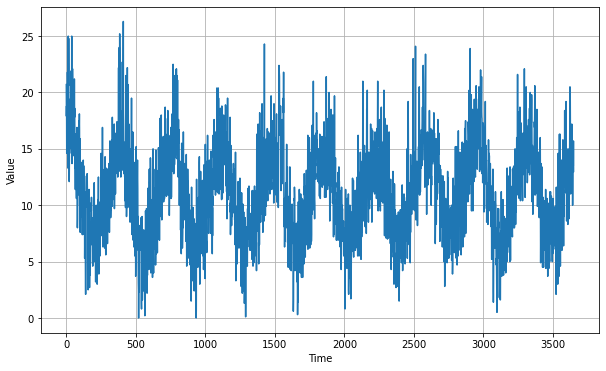

In [5]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  timestep = 0
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(timestep)
    timestep += 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000



In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 6s 493ms/step - loss: 31.9579 - mae: 32.4540
Epoch 2/100
12/12 [==============================] - 4s 318ms/step - loss: 31.2077 - mae: 31.7124
Epoch 3/100
12/12 [==============================] - 4s 313ms/step - loss: 30.0900 - mae: 30.5999
Epoch 4/100
12/12 [==============================] - 4s 313ms/step - loss: 28.7029 - mae: 29.2186
Epoch 5/100
12/12 [==============================] - 4s 316ms/step - loss: 26.9819 - mae: 27.5059
Epoch 6/100
12/12 [==============================] - 4s 315ms/step - loss: 24.7738 - mae: 25.3106
Epoch 7/100
12/12 [==============================] - 4s 320ms/step - loss: 21.8711 - mae: 22.4277
Epoch 8/100
12/12 [==============================] - 4s 323ms/step - loss: 18.1514 - mae: 18.7255
Epoch 9/100
12/12 [=

(1e-08, 0.0001, 0.0, 60.0)

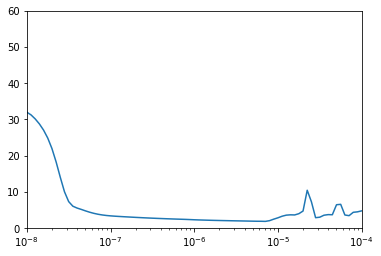

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs= 150)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/150
30/30 [==============================] - 6s 186ms/step - loss: 8.7446 - mae: 9.3412
Epoch 2/150
30/30 [==============================] - 4s 119ms/step - loss: 2.1995 - mae: 2.6654
Epoch 3/150
30/30 [==============================] - 4s 121ms/step - loss: 1.8733 - mae: 2.3287
Epoch 4/150
30/30 [==============================] - 4s 124ms/step - loss: 1.8211 - mae: 2.2749
Epoch 5/150
30/30 [==============================] - 4s 120ms/step - loss: 1.7811 - mae: 2.2337
Epoch 6/150
30/30 [==============================] - 3s 115ms/step - loss: 1.7505 - mae: 2.2022
Epoch 7/150
30/30 [==============================] - 3s 116ms/step - loss: 1.7232 - mae: 2.1740
Epoch 8/150
30/30 [==============================] - 3s 116ms/step - loss: 1.6992 - mae: 2.1493
Epoch 9/150
30/30 [==============================] - 3s 114ms/step - loss: 1.6789 - mae: 2.1282
Epoch 10/150
30/30 [==============================] - 3s 116ms/step - loss: 1.6616 - mae: 2.1101
Epoch 11/150
30/30 [===================

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

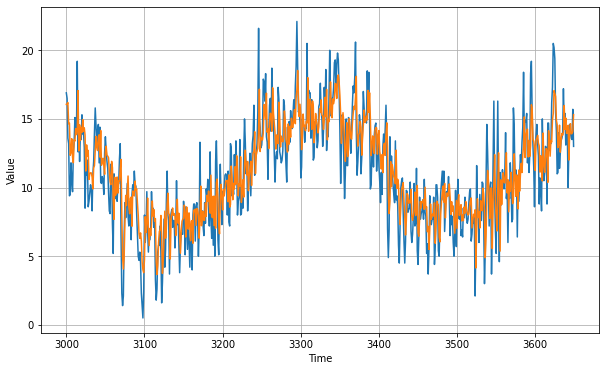

In [15]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.7539073

In [17]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[16.060982  16.078815  16.194304  14.643463  14.6887455 12.347964
 12.549838  13.557458  12.197688  11.806534  13.481114  13.3835335
 14.301698  13.85784   14.110455  17.064959  12.668964  14.570436
 13.429872  14.383298  14.020634  14.947351  14.101068  14.353603
 13.828174  11.203207  13.106677  12.290956  12.70822   10.592006
 11.011347  11.0787325 11.063532  10.758803   9.899023  11.434734
 11.598125  12.696873  13.729516  12.959644  12.697965  13.685362
 13.843766  12.217822  14.160109  11.625494  11.903978  12.137506
 11.615347  10.96473   12.669988  13.014608  12.347193  12.291648
 12.179954  11.19637   10.425869  10.210356  11.909873  11.456689
  9.12571    7.6844087 10.752158   9.438762   9.713088  10.769423
  9.59626   10.479456  10.477625  11.416373  12.051476   8.108435
  4.927328   4.0676928  4.937628   7.599877   9.431471   8.683941
  9.841898  10.841565   8.63236    8.089828   9.219256   9.310379
  7.1848335  9.746258   9.649559   9.389463  10.476629   9.773967
  9.90283